# Intuitive Project

### Problem

Bob the bird keeper has a problem that he thinks you can help him with. His birds are constantly harassed by the neighbor’s cats who are looking for a quick dinner. To protect his birds, Bob has setup a camera triggered alarm that goes off when a cat is nearby. In order to help Bob, please design and implement an automated algorithm that triggers when a cat is in view of the camera. To reassure him that his birds are alive and well, please also detect if a bird is present in the frame of view.

We have prepared a small dataset to help you out with this problem which contains images of birds and cats with corresponding annotations. The dataset can be downloaded here:

https://intusurg.box.com/s/yyfqxmjmjm7l7uktacb88yboekwxe7vg

For your model evaluation, please output a figure which properly depicts your results. We will ask you to describe your selected evaluation method and present the results.

### Package loading

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import copy


import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
import torchvision

seed = 42
np.random.seed(seed)

## Data loading

In [2]:
data_path = "dataset"
training_path = os.path.join(data_path, "training")
test_path = os.path.join(data_path, "test")

In [3]:
id_to_animal={
    0: "bird",
    1: "cat"
}

ratio = 0.8
subset = 100/100

Determine the validation and training sets by sampling the indexes (We look at the number of instances in each folders)

In [4]:
bird_path = os.path.join(training_path, "birds")
cats_path = os.path.join(training_path, "cats")
num_birds = num_cats = 0


for file in os.listdir(bird_path):
    #? do not count files other than images
    if file.endswith(".jpeg"):
        num_birds+=1

for file in os.listdir(cats_path):
    if file.endswith(".jpeg"):
        num_cats+=1



print(f"In the training set, we have {num_birds} instances of birds and {num_cats} instances of cats")


number_training_files = num_cats + num_birds

id_list = np.linspace(0, number_training_files-1, number_training_files).astype(int)
id_list = np.random.permutation(id_list)

#Determine the train/val index in our dataset
sampler_train = id_list[:int(len(id_list)*ratio)]
sampler_val = id_list[int(len(id_list)*ratio):]


In the training set, we have 5439 instances of birds and 5439 instances of cats


In [5]:
bird_path = os.path.join(test_path, "birds")
cats_path = os.path.join(test_path, "cats")
num_birds = num_cats = 0


for file in os.listdir(bird_path):
    if file.endswith(".jpeg"):
        num_birds+=1

for file in os.listdir(cats_path):
    if file.endswith(".jpeg"):
        num_cats+=1



print(f"In the testing set, we have {num_birds} instances of birds and {num_cats} instances of cats")


In the testing set, we have 86 instances of birds and 248 instances of cats


Overall, the training set is quite balanced regarding the number of birds and cats. We are using a simple sampler to determine which instance will go in the training and validation sets.

In [6]:
number_training_files

10878

## Data Loading

Define a set of transformations such as rescaling an normalization for our dataset

In [7]:
train_transforms = transforms.Compose([
                                #We add some rotation modifications to augment our dataset
                                transforms.RandomRotation(45),
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                #Apply a normalize step for compatibility with resnet pretrained
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

test_transforms = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    #Apply a normalize step for compatibility with resnet pretrained
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

Load directly our data from the images folders

In [8]:
train_data = datasets.ImageFolder(os.path.join(data_path, "training"),  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(os.path.join(data_path, "test"), 
                                    transform=test_transforms)

In [9]:
#Data Loading
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            sampler=SubsetRandomSampler(sampler_train))
val_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            sampler=SubsetRandomSampler(sampler_val))

#The test set is not shuffled on purpose
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False)

images-size: torch.Size([32, 3, 224, 224])
out-size: torch.Size([3, 906, 1810])


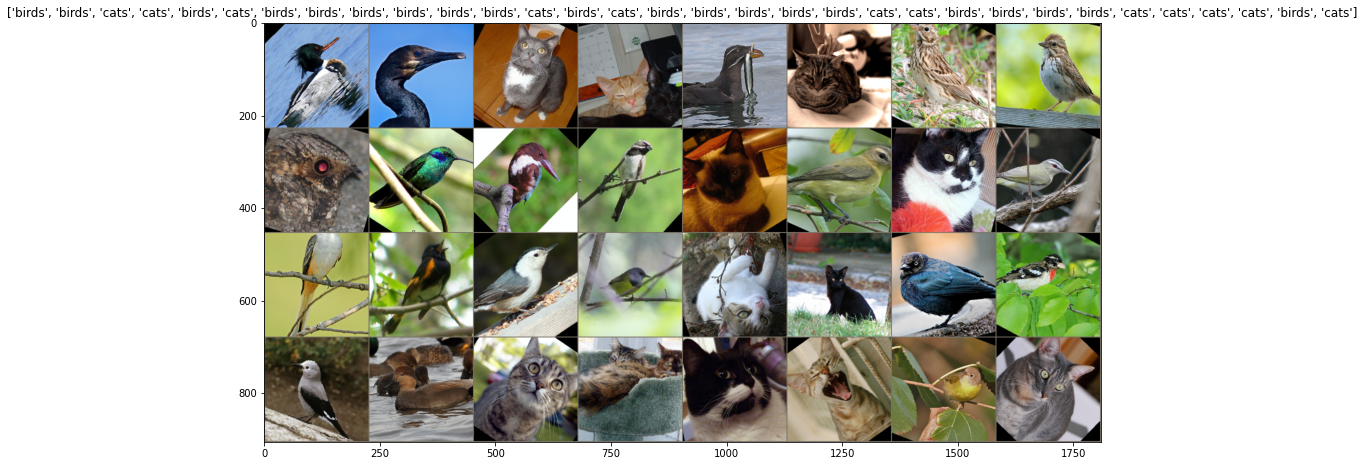

In [10]:
def imshow(inp, title=None):
    
    inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    
    #? renormalize the images for the human eye
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_loader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_data.classes[x] for x in labels])

We can see that our processing allows to represent cats and birds in a wide variety of position for our training set. 

images-size: torch.Size([32, 3, 224, 224])
out-size: torch.Size([3, 906, 1810])


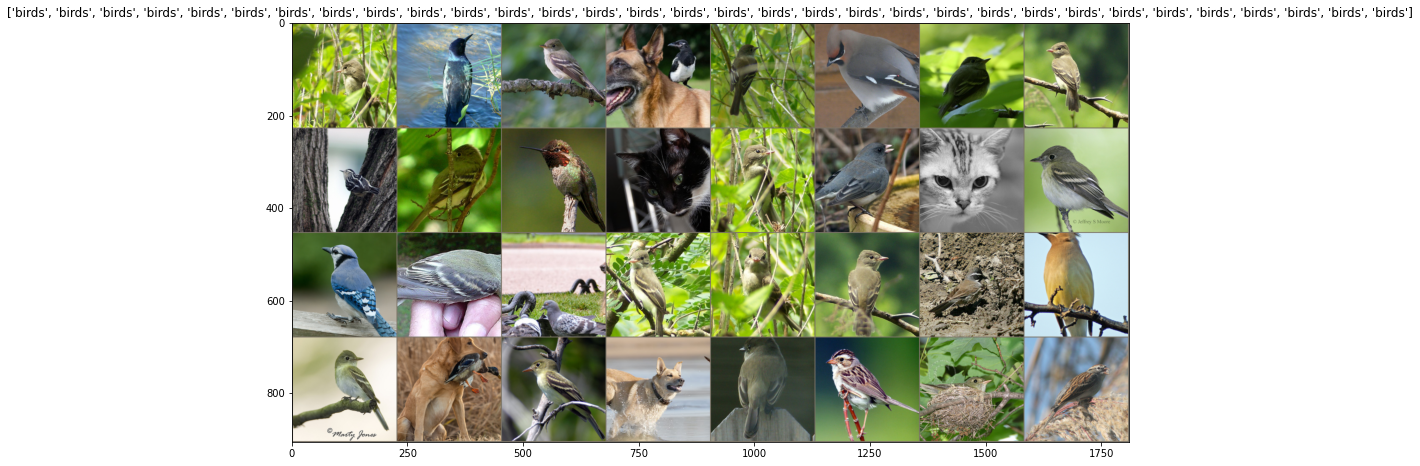

In [11]:
images, labels = next(iter(test_loader))
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[test_data.classes[x] for x in labels])

On our test set, which was not shuffled, we should normally only see birds. However, the presence of cats in our bird test folder. This might be a new kind of bird that I never heard before, who knows. However, in our case where a technical interview will happen, I will let those images there and discuss about this fact with you later on.
One thing to consider nonetheless, is that the test folder will probably display way worse results than the validation one.

## Strategy

The strategy for this work will be to use an already pretrained model, in our case resnet, to extract the features of the images. Then, we will simply retrain the end-layer of such network for our task.

In [12]:
model = torchvision.models.resnet18(pretrained=True)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### In our case, we will only modify the end-layer fc, with our custom layer.

Lets first define our loss and optimization constants.

In [13]:
#? Define the accuracy function
def accuracy(outputs, labels):
    pred = torch.argmax(outputs, dim=1)
    return torch.sum(pred==labels).item()

#Replace the end-layer with a simple two output layer for cats and birds
model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.classes))

ModelName = model.__class__.__name__

#? define the kind of loss and optimizer
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00004, momentum=0.8)

In [14]:
EPOCHS = 4
BATCH_SIZE = 100
val_losses = []
val_accs = []
train_losses = []
train_accs = []

best_val = np.Inf

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

#Data Loading
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=BATCH_SIZE, 
                                            sampler=SubsetRandomSampler(sampler_train))
val_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=BATCH_SIZE, 
                                            sampler=SubsetRandomSampler(sampler_val))


# Push the model to the desired hardware
model.to(device)

#Keep the best model
best_model = copy.deepcopy(model.state_dict())

daataset_size = len(train_data)

for epoch in range(EPOCHS):

    epoch_acc = 0
    epoch_loss = 0
    
    #! Training step
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = loss_fcn(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss +=loss.item()/len(sampler_train)
        epoch_acc += accuracy(outputs, target)/len(sampler_train)
        
        print(f"\r Epoch {epoch}: iteration {batch_idx}/{len(train_loader)}",end='')
        
    train_accs.append(epoch_acc*100)
    train_losses.append(epoch_loss)
    
    #! Validation step
    
    val_acc = 0
    val_loss = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = loss_fcn(outputs, target)

            val_loss += loss.item()/len(sampler_val)
            val_acc += accuracy(outputs, target)/len(sampler_val)

            print(f"\r Val {epoch}: iteration {batch_idx}/{len(val_loader)}",end='')
            
    val_accs.append(val_acc*100)
    val_losses.append(val_loss)
    print(f"\nEpoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc*100:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc*100:.2f}%")
    
    if val_loss < best_val:
        best_val = val_loss
        best_model = copy.deepcopy(model.state_dict())

Selected device is cuda


/home/peterbonnesoeur/Documents/intuitive/intuitive/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Val 0: iteration 21/2288
Epoch 0 --> loss:0.0053, acc:77.30%, val_loss:0.0043, val_acc:88.83%
 Val 1: iteration 21/2288
Epoch 1 --> loss:0.0037, acc:92.31%, val_loss:0.0031, val_acc:95.27%
 Val 2: iteration 21/2288
Epoch 2 --> loss:0.0028, acc:95.97%, val_loss:0.0025, val_acc:96.83%
 Val 3: iteration 21/2288
Epoch 3 --> loss:0.0023, acc:97.00%, val_loss:0.0020, val_acc:97.10%


In [15]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(best_model,os.path.join(SAVE_PATH,'model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'model.pt')))

Model is saved to /home/peterbonnesoeur/Documents/intuitive/models/model.pt


In [16]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'model.pt')))

Model is loaded from /home/peterbonnesoeur/Documents/intuitive/models/model.pt


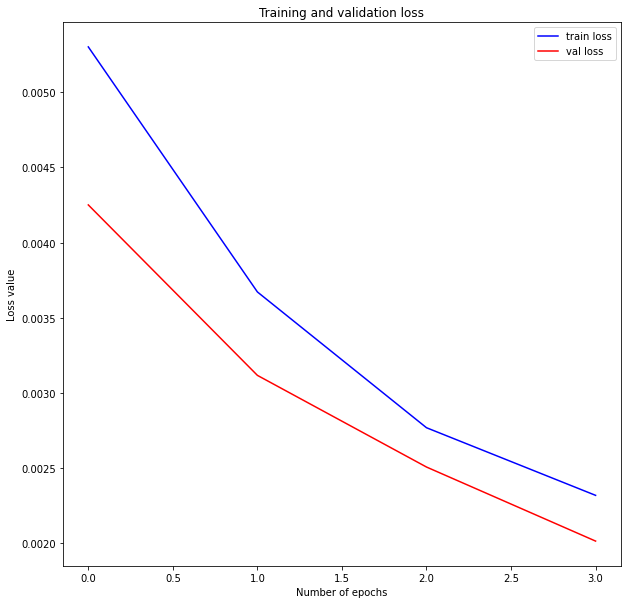

In [17]:
plt.figure(figsize=(10,10))

plt.plot(train_losses,'b')
plt.plot(val_losses,'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title("Training and validation loss")

plt.legend(['train loss','val loss'])

From the look of this graph, the model is learning the differences between birds and cats well enough. The loss is getting lower and lower after each epoch for both the training and the validation. Lets see if the qualitative analysis analysis satisfies us as well. 

## Evaluation (graphical on the val set)

Selected device is cuda


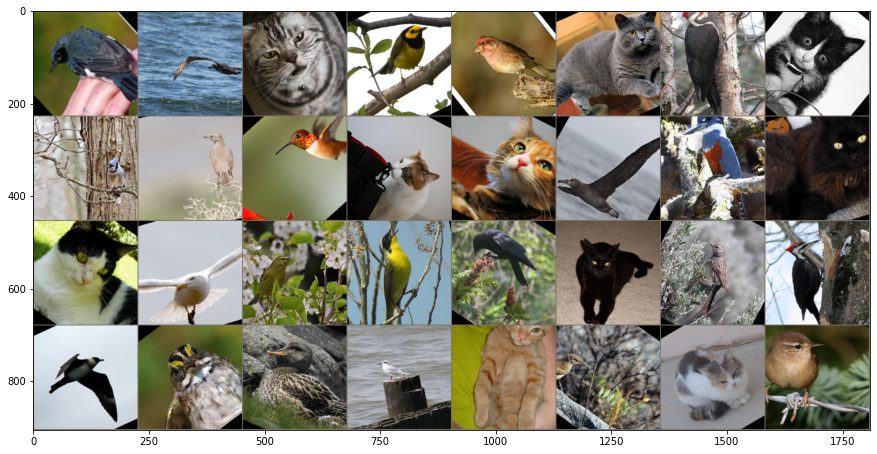

Predictions: ['birds', 'birds', 'cats', 'birds', 'birds', 'cats', 'birds', 'cats', 'birds', 'birds', 'birds', 'cats', 'cats', 'birds', 'birds', 'cats', 'cats', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'cats', 'birds']
Ground truth: ['birds', 'birds', 'cats', 'birds', 'birds', 'cats', 'birds', 'cats', 'birds', 'birds', 'birds', 'cats', 'cats', 'birds', 'birds', 'cats', 'cats', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'cats', 'birds']
Number of correct predictions for the val set: 32 over 32 labels (100.0% accuracy)


In [18]:
# Load the validation set
val_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            sampler=SubsetRandomSampler(sampler_val))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

model.to(device)

images, labels = next(iter(val_loader)) 

out = torchvision.utils.make_grid(images)

images = images.to(device)

# Compute the predictions
torch.argmax(model(images), dim = 1).tolist()

# extract the labels of the ground truth and of the prediction
preds = [train_data.classes[x] for x in torch.argmax(model(images), dim = 1)]
labels = [train_data.classes[x] for x in labels]


imshow(out, title="")

print("Predictions:", preds)
print("Ground truth:", labels)
evaluation = [True if preds[i] == labels[i] else False for i in range(len(labels))]

print(f"Number of correct predictions for the val set: {sum(evaluation)} over {len(evaluation)} labels ({sum(evaluation)/len(evaluation)*100}% accuracy)")


In the end, it seems that our model really understand that a cat and a bird aren't quite alike. We now need to look at our test set to evaluate our results

## Evaluation on the test set

**Disclaimer:** We could get better results during this step if we trained the network over the whole training set, without any splitting. Nonetheless, we will keep this notebook as short as possible and we will let the results as is.

In [22]:
test_acc = 0
test_loss = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

model.to(device)
    
#The test set is not shuffled on purpose
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = True)

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    
    outputs = model(data)
    loss = loss_fcn(outputs, target)

    test_loss += loss.item()/len(test_data)
    test_acc += accuracy(outputs, target)/len(test_data)

    print(f"\rIteration {batch_idx}/{len(test_loader)}",end='')



Selected device is cuda
Iteration 10/11

In [24]:
print(f"Test loss:{test_loss:.4f}, acc:{test_acc*100:.2f}%")

Test loss:0.0073, acc:95.51%


## Evaluation (graphical on the test set)

Selected device is cuda


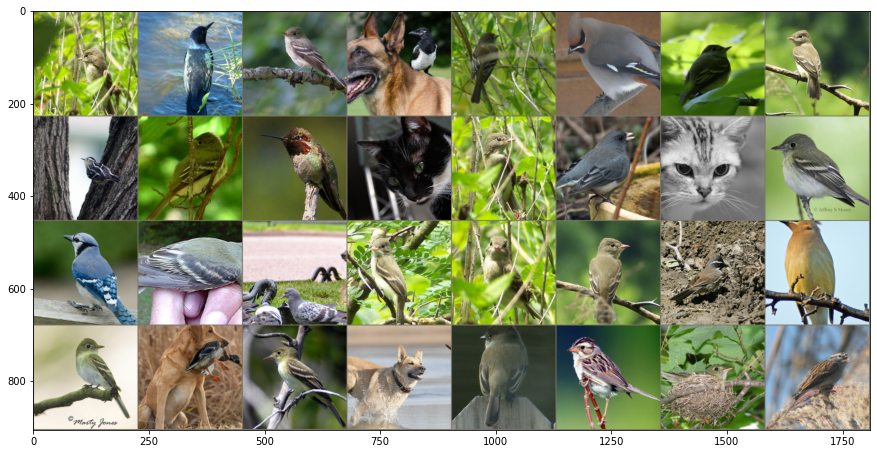

Predictions: ['birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'birds', 'cats', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'cats', 'birds', 'birds', 'birds', 'birds']
Ground truth: ['birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds', 'birds']

Number of correct predictions for the test set: 29 over 32 labels (90.625% accuracy)


In [25]:
# Load the test set
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

model.to(device)

images, labels = next(iter(test_loader)) 

out = torchvision.utils.make_grid(images)

images = images.to(device)

# Compute the predictions
torch.argmax(model(images), dim = 1).tolist()

# extract the labels of the ground truth and of the prediction
preds = [test_data.classes[x] for x in torch.argmax(model(images), dim = 1)]
labels = [test_data.classes[x] for x in labels]


imshow(out, title="")

print("Predictions:", preds)
print("Ground truth:", labels)
evaluation = [True if preds[i] == labels[i] else False for i in range(len(labels))]

print(f"\nNumber of correct predictions for the test set: {sum(evaluation)} over {len(evaluation)} labels ({sum(evaluation)/len(evaluation)*100}% accuracy)")


Even with the tricky elements from the test set, the classifier still works really well for this task (I still see two cats in this window wand the algortihm also think so). 

I hope that Bob will be reassured to see his birds safe and the cats away.

## Conclusion

Thank you for your time assessing this assignment. I am looking forward to discuss with you about this position that you have available.